In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from sklearn import covariance

import udacityhelpers as udacity
import lanelines
import lanefinder

In [3]:
import imageio

In [4]:
import lanespipeline 

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [5]:
cg = lanespipeline.computational_graph
params = lanespipeline.parameters.copy()
params['canny_lo'] = 50
params['canny_hi'] = 150

finder, find_and_draw_lanes = lanefinder.create_objects(cg, params)

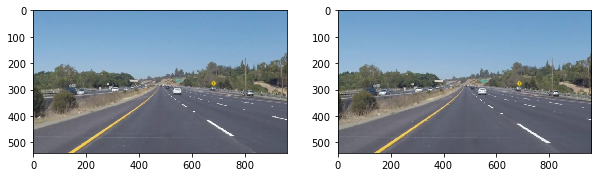

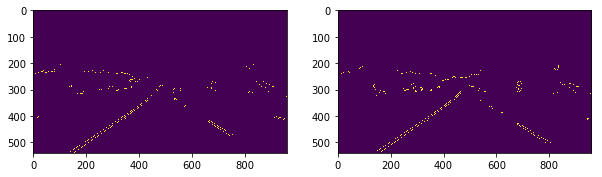

In [6]:
video_yellow = imageio.get_reader('test_videos/solidYellowLeft.mp4')
frame_good = video_yellow.get_data(24) 
frame_bad = video_yellow.get_data(25) 

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(frame_good)
plt.subplot(1, 2, 2)
plt.imshow(frame_bad)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
finder.process(frame_good)
plt.imshow(finder['image_canny'])
plt.subplot(1, 2, 2)
finder.process(frame_bad)
plt.imshow(finder['image_canny'])

In [7]:
def line_slope(line):
    x1, y1, x2, y2 = line
    return (y2 - y1) / (x2 - x1)


frame_slopes = np.zeros((len(video_yellow), 2))
for i, frame in enumerate(video_yellow):
    finder.process(frame)
    sl_1 = line_slope(finder['avg_line_left'])
    sl_2 = line_slope(finder['avg_line_right'])
    
    if math.isnan(sl_1) or math.isnan(sl_2):
        print(i, finder['avg_line_left'], finder['avg_line_right'])
    
    frame_slopes[i, 0] = sl_1
    frame_slopes[i, 1] = sl_2

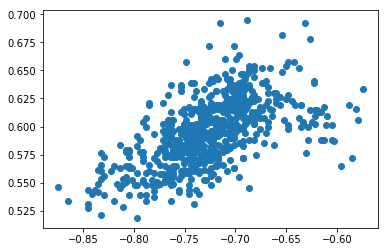

In [8]:
plt.plot(frame_slopes[:, 0], frame_slopes[:, 1], 'o')

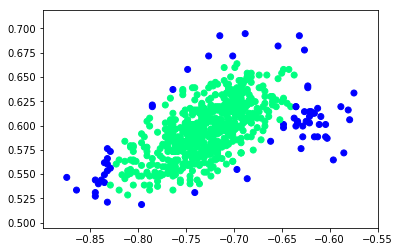

In [9]:
anomaly_detector = covariance.EllipticEnvelope().fit(frame_slopes)
frame_slopes_labels = anomaly_detector.predict(frame_slopes)

plt.scatter(frame_slopes[:, 0], frame_slopes[:, 1], c=frame_slopes_labels, cmap='winter')

In [10]:
#bad_frames_indices = np.where(frame_slopes_labels == -1)[0]
bad_frames_indices = np.where(frame_slopes[:, 1] < 0.5)[0]

for i in bad_frames_indices[:4]:
        
    frame = video_yellow.get_data(i) 
    finder.process(frame)
    
    plt.figure(figsize=(15, 10))
    plt.title(i)
    
    plt.subplot(1, 3, 1)
    plt.imshow(finder['masked_image'])
    lanelines.plot_line(finder['avg_line_left'], color='r')
    lanelines.plot_line(finder['avg_line_right'], color='r')

    plt.subplot(1, 3, 2)
    lanelines.draw_lines_on_image(frame, finder['lines'])
    plt.imshow(frame)
        
    canvas = np.zeros_like(frame)
    lanelines.draw_lines_on_image(canvas, finder['extended_lines_left'])
    lanelines.draw_line(canvas, finder['avg_line_left'], color=[0, 0, 255], thickness=5)
    lanelines.draw_lines_on_image(canvas, finder['extended_lines_right'], color=[0, 255, 0])
    lanelines.draw_line(canvas, finder['avg_line_right'], color=[0, 0, 255], thickness=5)
    
    plt.subplot(1, 3, 3)
    plt.imshow(canvas)


In [11]:
finder['tangents'][finder['tangents'] > 0]

array([ 0.57142857,  0.58333333,  0.60465116,  0.60606061,  0.6       ,
        0.57692308,  0.6       ,  0.63636364,  0.58333333])